# 目的

- バックテストの部分を書く
- 機械学習をどこに入れるか
- ATR（いわゆる幅てきなやつ）

In [102]:
import os 
import sys 
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import talib
import requests

# 仮想通貨関連
import ccxt
import pybitflyer

In [2]:
# ここのハードコーディング危険
api_key = '82BLyXP8xgK2JLjsKFMajV'
api_secret = 'uYu8qv+y9F7EBjzhfa2kitidpVfdyH4/riCopxQho+k='

--> lightning fxもできることがわかった！

In [3]:
bitflyer = ccxt.bitflyer({
'apiKey': api_key,
'secret': api_secret
})

In [ ]:
# ろうそく足データの取得

In [11]:
def requests_to_cryptocompare(toTs = -1):
    return requests.get('https://min-api.cryptocompare.com/data/v2/histohour', params={
       'fsym': "BTC",     # 仮想通貨のシンボル
       'tsym': "JPY",     # ペアの通貨のシンボル
       'limit': 2000,     # レコードの取得数、最大2000
       'e': "bitFlyerFX", # 取引所
       'toTs': toTs       # 取得したいデータの基準となるタイムスタンプ(unixtime)
       })

req = requests_to_cryptocompare()
print(req.text)

{"Response":"Success","Message":"","HasWarning":false,"Type":100,"RateLimit":{},"Data":{"Aggregated":false,"TimeFrom":1634785200,"TimeTo":1641985200,"Data":[{"time":1634785200,"close":7790368,"high":7808405,"low":7708714,"open":7765241,"volumefrom":318.39,"volumeto":2467146027.94,"conversionType":"force_direct","conversionSymbol":""},{"time":1634788800,"close":7773913,"high":7806487,"low":7721390,"open":7790368,"volumefrom":221.78,"volumeto":1722259146.4,"conversionType":"force_direct","conversionSymbol":""},{"time":1634792400,"close":7739000,"high":7796948,"low":7738716,"open":7773913,"volumefrom":130.07,"volumeto":1010517635.79,"conversionType":"force_direct","conversionSymbol":""},{"time":1634796000,"close":7650723,"high":7753882,"low":7547473,"open":7739000,"volumefrom":538.13,"volumeto":4121278332.88,"conversionType":"force_direct","conversionSymbol":""},{"time":1634799600,"close":7794198,"high":7898482,"low":7632316,"open":7650723,"volumefrom":347.5,"volumeto":2685643277.78,"conv

In [13]:
# わかりやすいやつ
http://nipper.work/btc/index.php?market=bitFlyer&coin=BTCJPY&periods=86400&after=1420070400

SyntaxError: invalid syntax (<ipython-input-13-329c7ec9521c>, line 2)

In [122]:
# CryptowatchからOHLCデータ取得
df_btc = pd.read_csv("../data/nb002/btc_jpy_15min.csv")
df_btc.columns = ["time", "op", "hi", "lo", "cl", "volume"]

In [123]:
df_btc_train = df_btc[pd.to_datetime(df_btc["time"])<pd.to_datetime("2021-12-01")]
df_btc_test = df_btc[pd.to_datetime(df_btc["time"])>=pd.to_datetime("2021-12-01")]

In [124]:
df_btc_train

,time,op,hi,lo,cl,volume
0,2021-10-27 13:15:00,6720546,6738258,6710000,6735988,20.589480
1,2021-10-27 13:30:00,6738258,6739563,6708000,6710000,14.918648
2,2021-10-27 13:45:00,6711247,6722993,6700000,6722993,22.997577
3,2021-10-27 14:00:00,6720612,6736192,6704518,6710000,17.630379
4,2021-10-27 14:15:00,6713667,6723157,6704320,6704320,16.902241
...,...,...,...,...,...,...
3302,2021-11-30 22:45:00,6504166,6506439,6485316,6500000,6.466320
3303,2021-11-30 23:00:00,6496913,6500930,6479772,6491062,5.330892
3304,2021-11-30 23:15:00,6488943,6503746,6462535,6470978,23.821248
3305,2021-11-30 23:30:00,6475942,6501111,6472106,6493391,16.240694


# 取り決め

* 現在ポジションがプラスの場合、エグジット用の売り指値を出す
* 現在ポジションがマイナスの場合、エグジット用の買い指値を出す
* 最大ポジションまで余裕があり、y_pred_buyがプラスのとき、エントリー用の買い指値を出す
* 最大ポジションまで余裕があり、y_pred_sellがプラスのとき、エントリー用の売り指値を出す

In [10]:
def calc_features(df):
    open = df['op']
    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    
    orig_columns = df.columns

    hilo = (df['hi'] + df['lo']) / 2
    df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] -= hilo
    df['BBANDS_middleband'] -= hilo
    df['BBANDS_lowerband'] -= hilo
    df['DEMA'] = talib.DEMA(close, timeperiod=30) - hilo
    df['EMA'] = talib.EMA(close, timeperiod=30) - hilo
    df['HT_TRENDLINE'] = talib.HT_TRENDLINE(close) - hilo
    df['KAMA'] = talib.KAMA(close, timeperiod=30) - hilo
    df['MA'] = talib.MA(close, timeperiod=30, matype=0) - hilo
    df['MIDPOINT'] = talib.MIDPOINT(close, timeperiod=14) - hilo
    df['SMA'] = talib.SMA(close, timeperiod=30) - hilo
    df['T3'] = talib.T3(close, timeperiod=5, vfactor=0) - hilo
    df['TEMA'] = talib.TEMA(close, timeperiod=30) - hilo
    df['TRIMA'] = talib.TRIMA(close, timeperiod=30) - hilo
    df['WMA'] = talib.WMA(close, timeperiod=30) - hilo

    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
    df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
    df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
    df['BOP'] = talib.BOP(open, high, low, close)
    df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
    df['DX'] = talib.DX(high, low, close, timeperiod=14)
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    # skip MACDEXT MACDFIX たぶん同じなので
    df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
    df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
    df['MOM'] = talib.MOM(close, timeperiod=10)
    df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
    df['RSI'] = talib.RSI(close, timeperiod=14)
    df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['TRIX'] = talib.TRIX(close, timeperiod=30)
    df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)

    df['AD'] = talib.AD(high, low, close, volume)
    df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    df['OBV'] = talib.OBV(close, volume)

    df['ATR'] = talib.ATR(high, low, close, timeperiod=14)
    df['NATR'] = talib.NATR(high, low, close, timeperiod=14)
    df['TRANGE'] = talib.TRANGE(high, low, close)

    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
    df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)

    df['BETA'] = talib.BETA(high, low, timeperiod=5)
    df['CORREL'] = talib.CORREL(high, low, timeperiod=30)
    df['LINEARREG'] = talib.LINEARREG(close, timeperiod=14) - close
    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)
    df['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14)
    df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1)

    return df

In [11]:
features = sorted([
    'ADX',
    'ADXR',
    'APO',
    'AROON_aroondown',
    'AROON_aroonup',
    'AROONOSC',
    'CCI',
    'DX',
    'MACD_macd',
    'MACD_macdsignal',
    'MACD_macdhist',
    'MFI',
#     'MINUS_DI',
#     'MINUS_DM',
    'MOM',
#     'PLUS_DI',
#     'PLUS_DM',
    'RSI',
    'STOCH_slowk',
    'STOCH_slowd',
    'STOCHF_fastk',
#     'STOCHRSI_fastd',
    'ULTOSC',
    'WILLR',
#     'ADOSC',
#     'NATR',
    'HT_DCPERIOD',
    'HT_DCPHASE',
    'HT_PHASOR_inphase',
    'HT_PHASOR_quadrature',
    'HT_TRENDMODE',
    'BETA',
    'LINEARREG',
    'LINEARREG_ANGLE',
    'LINEARREG_INTERCEPT',
    'LINEARREG_SLOPE',
    'STDDEV',
    'BBANDS_upperband',
    'BBANDS_middleband',
    'BBANDS_lowerband',
    'DEMA',
    'EMA',
    'HT_TRENDLINE',
    'KAMA',
    'MA',
    'MIDPOINT',
    'T3',
    'TEMA',
    'TRIMA',
    'WMA',
])

In [125]:
df_btc_train = calc_features(df_btc_train)

<ipython-input-10-549ecda6586e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
<ipython-input-10-549ecda6586e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BBANDS_upperband'] -= hilo
<ipython-input-10-549ecda6586e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [126]:
df_btc_train

,time,op,hi,lo,cl,volume,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,...,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV
0,2021-10-27 13:15:00,6720546,6738258,6710000,6735988,20.589480,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-10-27 13:30:00,6738258,6739563,6708000,6710000,14.918648,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-10-27 13:45:00,6711247,6722993,6700000,6722993,22.997577,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-10-27 14:00:00,6720612,6736192,6704518,6710000,17.630379,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-10-27 14:15:00,6713667,6723157,6704320,6704320,16.902241,25806.896487,2921.7,-19963.496487,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,11442.598244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3302,2021-11-30 22:45:00,6504166,6506439,6485316,6500000,6.466320,26528.407742,-14235.5,-54999.407742,4581.624408,...,0.282671,0.878147,0,1.057645,0.881033,-22127.771429,-89.983638,23394.342857,-3501.701099,20381.953871
3303,2021-11-30 23:00:00,6496913,6500930,6479772,6491062,5.330892,24961.231702,-445.2,-25851.631702,8629.555155,...,0.553273,0.980243,0,0.497771,0.845154,-8883.857143,-89.974116,19892.000000,-2213.527473,12703.215851
3304,2021-11-30 23:15:00,6488943,6503746,6462535,6470978,23.821248,31670.574594,6999.9,-17670.774594,12005.267472,...,0.668241,0.998566,0,0.648940,0.766211,7527.771429,-89.974800,37085.514286,-2273.672527,12335.337297
3305,2021-11-30 23:30:00,6475942,6501111,6472106,6493391,16.240694,29244.848269,5626.1,-17992.648269,7879.444881,...,0.736972,0.999068,1,0.473873,0.824342,-10397.685714,-89.953844,5739.971429,-1241.358242,11809.374134


In [127]:
df_btc_train = df_btc_train.dropna()

In [128]:
df_btc_train

,time,op,hi,lo,cl,volume,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,...,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV
88,2021-10-28 11:15:00,6941093,6945820,6923289,6923289,8.492828,21399.589381,4130.9,-13137.789381,-34655.688807,...,0.380098,-0.385266,1,-0.080960,0.987324,61453.314286,89.996419,-146551.600000,16000.378022,8634.344691
89,2021-10-28 11:30:00,6923289,6938000,6911450,6926136,20.001185,31928.996513,11849.4,-8230.196513,-16774.700420,...,0.252738,-0.505438,1,0.721980,0.987655,46264.914286,89.995126,-106557.342857,11755.558242,10039.798257
90,2021-10-28 11:45:00,6928000,6933795,6918711,6920519,9.707317,25994.204748,5205.6,-15583.004748,-11882.300279,...,0.107700,-0.626839,1,0.779778,0.987466,35815.885714,89.992144,-58996.600000,7293.268132,10394.302374
91,2021-10-28 12:00:00,6920519,6937000,6920232,6933481,20.071957,14304.971733,69.0,-14166.971733,-6982.459780,...,-0.036076,-0.732156,1,0.393791,0.987338,12454.971429,89.986154,-41339.828571,4138.061538,7117.985867
92,2021-10-28 12:15:00,6933478,6947765,6924658,6941647,19.353866,8107.025226,-7197.1,-22501.225226,-7153.028772,...,-0.192366,-0.829924,1,0.420704,0.987681,1352.771429,89.979277,-34590.057143,2764.832967,7652.062613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3302,2021-11-30 22:45:00,6504166,6506439,6485316,6500000,6.466320,26528.407742,-14235.5,-54999.407742,4581.624408,...,0.282671,0.878147,0,1.057645,0.881033,-22127.771429,-89.983638,23394.342857,-3501.701099,20381.953871
3303,2021-11-30 23:00:00,6496913,6500930,6479772,6491062,5.330892,24961.231702,-445.2,-25851.631702,8629.555155,...,0.553273,0.980243,0,0.497771,0.845154,-8883.857143,-89.974116,19892.000000,-2213.527473,12703.215851
3304,2021-11-30 23:15:00,6488943,6503746,6462535,6470978,23.821248,31670.574594,6999.9,-17670.774594,12005.267472,...,0.668241,0.998566,0,0.648940,0.766211,7527.771429,-89.974800,37085.514286,-2273.672527,12335.337297
3305,2021-11-30 23:30:00,6475942,6501111,6472106,6493391,16.240694,29244.848269,5626.1,-17992.648269,7879.444881,...,0.736972,0.999068,1,0.473873,0.824342,-10397.685714,-89.953844,5739.971429,-1241.358242,11809.374134


In [129]:
# 呼び値 (取引所、取引ペアごとに異なるので、適切に設定してください)
pips = 1

# ATRで指値距離を計算します
limit_price_dist = df_btc_train['ATR'] * 0.5
#limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips

In [130]:
limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips

In [131]:
limit_price_dist

88      17007.0
89      16740.0
90      16083.0
91      15533.0
92      15249.0
         ...   
3302    21736.0
3303    20939.0
3304    20916.0
3305    20498.0
3306    20089.0
Name: ATR, Length: 3219, dtype: float64

In [132]:
df_btc_train['buy_price'] = df_btc_train['cl'] - limit_price_dist
df_btc_train['sell_price'] = df_btc_train['cl'] + limit_price_dist

<ipython-input-132-67dc2e66acc5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc_train['buy_price'] = df_btc_train['cl'] - limit_price_dist
<ipython-input-132-67dc2e66acc5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc_train['sell_price'] = df_btc_train['cl'] + limit_price_dist


In [133]:
df_btc_train

,time,op,hi,lo,cl,volume,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,...,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,buy_price,sell_price
88,2021-10-28 11:15:00,6941093,6945820,6923289,6923289,8.492828,21399.589381,4130.9,-13137.789381,-34655.688807,...,1,-0.080960,0.987324,61453.314286,89.996419,-146551.600000,16000.378022,8634.344691,6906282.0,6940296.0
89,2021-10-28 11:30:00,6923289,6938000,6911450,6926136,20.001185,31928.996513,11849.4,-8230.196513,-16774.700420,...,1,0.721980,0.987655,46264.914286,89.995126,-106557.342857,11755.558242,10039.798257,6909396.0,6942876.0
90,2021-10-28 11:45:00,6928000,6933795,6918711,6920519,9.707317,25994.204748,5205.6,-15583.004748,-11882.300279,...,1,0.779778,0.987466,35815.885714,89.992144,-58996.600000,7293.268132,10394.302374,6904436.0,6936602.0
91,2021-10-28 12:00:00,6920519,6937000,6920232,6933481,20.071957,14304.971733,69.0,-14166.971733,-6982.459780,...,1,0.393791,0.987338,12454.971429,89.986154,-41339.828571,4138.061538,7117.985867,6917948.0,6949014.0
92,2021-10-28 12:15:00,6933478,6947765,6924658,6941647,19.353866,8107.025226,-7197.1,-22501.225226,-7153.028772,...,1,0.420704,0.987681,1352.771429,89.979277,-34590.057143,2764.832967,7652.062613,6926398.0,6956896.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3302,2021-11-30 22:45:00,6504166,6506439,6485316,6500000,6.466320,26528.407742,-14235.5,-54999.407742,4581.624408,...,0,1.057645,0.881033,-22127.771429,-89.983638,23394.342857,-3501.701099,20381.953871,6478264.0,6521736.0
3303,2021-11-30 23:00:00,6496913,6500930,6479772,6491062,5.330892,24961.231702,-445.2,-25851.631702,8629.555155,...,0,0.497771,0.845154,-8883.857143,-89.974116,19892.000000,-2213.527473,12703.215851,6470123.0,6512001.0
3304,2021-11-30 23:15:00,6488943,6503746,6462535,6470978,23.821248,31670.574594,6999.9,-17670.774594,12005.267472,...,0,0.648940,0.766211,7527.771429,-89.974800,37085.514286,-2273.672527,12335.337297,6450062.0,6491894.0
3305,2021-11-30 23:30:00,6475942,6501111,6472106,6493391,16.240694,29244.848269,5626.1,-17992.648269,7879.444881,...,1,0.473873,0.824342,-10397.685714,-89.953844,5739.971429,-1241.358242,11809.374134,6472893.0,6513889.0


In [134]:
df_btc_train["buy_price"].size

3219

In [135]:
# 約定判断
df['long'] = df['low'] < df['buy']    # 買い指値ヒット
df['short'] = df['high'] > df['sell'] # 売り指値ヒット

NameError: name 'df' is not defined

In [136]:
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    y = entry_price.copy()
    y[:] = np.nan
    force_entry_time = entry_price.copy()
    force_entry_time[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                force_entry_time[i] = j - i
                break
    return y, force_entry_time

In [137]:
entry_price_buy = df_btc_train["buy_price"].values
lo = df_btc_train["lo"].values
y_buy = entry_price_buy.copy()
y_buy[:] = np.nan
y_buy_t = entry_price_buy.copy()
y_buy_t[:] = np.nan

for i in range(entry_price_buy.size):
    for j in range(i+1,entry_price_buy.size):
        if round(lo[j]) < round(entry_price_buy[j-1]):
            y_buy[i] = entry_price_buy[j-1]
            y_buy_t[i] = j - i 
            break

In [138]:
entry_price_sell = df_btc_train["sell_price"].values
hi = df_btc_train["hi"].values
y_sell = entry_price_sell.copy()
y_sell[:] = np.nan
y_sell_t = entry_price_sell.copy()
y_sell_t[:] = np.nan

for i in range(entry_price_sell.size):
    for j in range(i+1,entry_price_sell.size):
        if round(hi[j]) > round(entry_price_sell[j-1]):
            y_sell[i] = entry_price_sell[j-1]
            y_sell_t[i] = j - i 
            break

In [139]:
df_btc_train['buy_fep'] = y_buy
df_btc_train['sell_fep'] = y_sell

<ipython-input-139-7cc3143dcdfb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc_train['buy_fep'] = y_buy
<ipython-input-139-7cc3143dcdfb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc_train['sell_fep'] = y_sell


In [140]:
df_btc_train['buy_price']

88      6906282.0
89      6909396.0
90      6904436.0
91      6917948.0
92      6926398.0
          ...    
3302    6478264.0
3303    6470123.0
3304    6450062.0
3305    6472893.0
3306    6458968.0
Name: buy_price, Length: 3219, dtype: float64

In [141]:
df_btc_train['buy_fep']

88      6940510.0
89      6940510.0
90      6940510.0
91      6940510.0
92      6940510.0
          ...    
3302    6470123.0
3303    6470123.0
3304    6472893.0
3305    6472893.0
3306          NaN
Name: buy_fep, Length: 3219, dtype: float64

In [142]:
df_btc_train['buy_executed'] = ((df_btc_train['buy_price']).round() > (df_btc_train['lo'].shift(-1)).round()).astype('float64')
df_btc_train['sell_executed'] = ((df_btc_train['sell_price']).round() < (df_btc_train['hi'].shift(-1)).round()).astype('float64')

<ipython-input-142-6bdd254b78ea>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc_train['buy_executed'] = ((df_btc_train['buy_price']).round() > (df_btc_train['lo'].shift(-1)).round()).astype('float64')
<ipython-input-142-6bdd254b78ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc_train['sell_executed'] = ((df_btc_train['sell_price']).round() < (df_btc_train['hi'].shift(-1)).round()).astype('float64')


In [143]:
horizon = 1

In [144]:
df_btc_train['y_buy'] = np.where(
    df_btc_train['buy_executed'],
    df_btc_train['sell_fep'].shift(-horizon) / df_btc_train['buy_price'] - 1,
    0
)
df_btc_train['y_sell'] = np.where(
    df_btc_train['sell_executed'],
    df_btc_train['sell_price'] / df_btc_train['buy_fep'].shift(-horizon) -1,
    0
)

<ipython-input-144-f52338890e15>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc_train['y_buy'] = np.where(
<ipython-input-144-f52338890e15>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc_train['y_sell'] = np.where(


In [145]:
df_btc_train

,time,op,hi,lo,cl,volume,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,...,LINEARREG_SLOPE,STDDEV,buy_price,sell_price,buy_fep,sell_fep,buy_executed,sell_executed,y_buy,y_sell
88,2021-10-28 11:15:00,6941093,6945820,6923289,6923289,8.492828,21399.589381,4130.9,-13137.789381,-34655.688807,...,16000.378022,8634.344691,6906282.0,6940296.0,6940510.0,6936602.0,0.0,0.0,0.000000,0.000000
89,2021-10-28 11:30:00,6923289,6938000,6911450,6926136,20.001185,31928.996513,11849.4,-8230.196513,-16774.700420,...,11755.558242,10039.798257,6909396.0,6942876.0,6940510.0,6936602.0,0.0,0.0,0.000000,0.000000
90,2021-10-28 11:45:00,6928000,6933795,6918711,6920519,9.707317,25994.204748,5205.6,-15583.004748,-11882.300279,...,7293.268132,10394.302374,6904436.0,6936602.0,6940510.0,6936602.0,0.0,1.0,0.000000,-0.000563
91,2021-10-28 12:00:00,6920519,6937000,6920232,6933481,20.071957,14304.971733,69.0,-14166.971733,-6982.459780,...,4138.061538,7117.985867,6917948.0,6949014.0,6940510.0,6952961.0,0.0,0.0,0.000000,0.000000
92,2021-10-28 12:15:00,6933478,6947765,6924658,6941647,19.353866,8107.025226,-7197.1,-22501.225226,-7153.028772,...,2764.832967,7652.062613,6926398.0,6956896.0,6940510.0,6952961.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3302,2021-11-30 22:45:00,6504166,6506439,6485316,6500000,6.466320,26528.407742,-14235.5,-54999.407742,4581.624408,...,-3501.701099,20381.953871,6478264.0,6521736.0,6470123.0,6491894.0,0.0,0.0,0.000000,0.000000
3303,2021-11-30 23:00:00,6496913,6500930,6479772,6491062,5.330892,24961.231702,-445.2,-25851.631702,8629.555155,...,-2213.527473,12703.215851,6470123.0,6512001.0,6470123.0,6491894.0,1.0,0.0,0.003365,0.000000
3304,2021-11-30 23:15:00,6488943,6503746,6462535,6470978,23.821248,31670.574594,6999.9,-17670.774594,12005.267472,...,-2273.672527,12335.337297,6450062.0,6491894.0,6472893.0,6491894.0,0.0,1.0,0.000000,0.002935
3305,2021-11-30 23:30:00,6475942,6501111,6472106,6493391,16.240694,29244.848269,5626.1,-17992.648269,7879.444881,...,-1241.358242,11809.374134,6472893.0,6513889.0,6472893.0,NaN,1.0,0.0,NaN,0.000000


<AxesSubplot:>

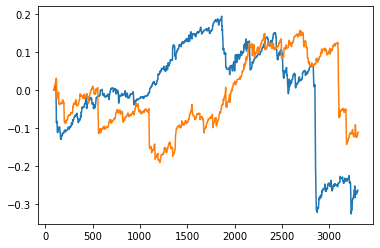

In [146]:
df_btc_train['y_buy'].cumsum().plot(label='買い')
df_btc_train['y_sell'].cumsum().plot(label='売り')

In [147]:
print('毎時刻、この執行方法でトレードした場合の累積リターン')
df['y_buy'].cumsum().plot(label='買い')
df['y_sell'].cumsum().plot(label='売り')
plt.title('累積リターン')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

毎時刻、この執行方法でトレードした場合の累積リターン


NameError: name 'df' is not defined

# テストデータ

In [148]:
df_btc_test = calc_features(df_btc_test)

<ipython-input-10-549ecda6586e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
<ipython-input-10-549ecda6586e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BBANDS_upperband'] -= hilo
<ipython-input-10-549ecda6586e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [149]:
df_btc_test.dropna()

,time,op,hi,lo,cl,volume,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,...,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV
3395,2021-12-01 22:00:00,6413616,6437551,6398077,6433664,32.432847,29767.226714,-2366.4,-34500.026714,41418.029249,...,-0.007260,0.701955,1,0.465992,0.985610,-25668.342857,-89.992111,68747.771429,-7262.778022,16066.813357
3396,2021-12-01 22:15:00,6433664,6447551,6415000,6420000,29.253288,17834.424156,-14283.9,-46402.224156,21058.656188,...,0.074671,0.757933,1,0.580569,0.985697,-13129.828571,-89.991102,70581.257143,-6439.314286,16059.162078
3397,2021-12-01 22:30:00,6418900,6423246,6398800,6423246,25.139641,35207.777474,4707.2,-25793.377474,35545.362360,...,0.207357,0.838362,1,0.584063,0.985215,-17388.428571,-89.990271,59168.571429,-5889.000000,15250.288737
3398,2021-12-01 22:45:00,6423246,6438755,6403012,6425085,15.659732,15357.036138,2238.7,-10879.636138,20771.603193,...,0.295673,0.884564,0,0.510443,0.985714,-24403.857143,-89.991182,60062.000000,-6497.373626,6559.168069
3399,2021-12-01 23:00:00,6425085,6450062,6420000,6444100,11.195659,11599.693358,-5812.0,-23223.693358,4629.793753,...,0.406805,0.933607,1,0.656517,0.985333,-36144.485714,-89.988199,26972.628571,-4855.162637,8705.846679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5994,2021-12-28 23:45:00,5475000,5484560,5468904,5480311,16.271515,15321.076139,-7746.0,-30813.076139,-29528.220076,...,0.721690,0.999783,1,0.542351,0.941790,-20722.971429,-89.973504,7388.257143,-2162.402198,11533.538069
5995,2021-12-29 00:00:00,5478197,5480487,5454215,5456831,17.486344,20255.028515,3410.8,-13433.428515,-22169.087173,...,0.254971,0.864028,1,0.531463,0.945642,530.542857,-89.973461,28596.171429,-2158.894505,8422.114257
5996,2021-12-29 00:15:00,5455923,5488466,5447625,5488285,38.533803,26924.903529,5027.1,-16870.703529,-20656.837829,...,0.007256,0.712219,1,0.092165,0.930088,-21305.342857,-89.875184,-15337.800000,-459.041758,10948.901764
5997,2021-12-29 00:30:00,5487234,5490928,5477848,5481000,19.962052,12974.994623,-8302.6,-29580.194623,-35807.598443,...,-0.049802,0.671014,1,0.229196,0.903572,-8655.857143,89.869584,-14367.142857,439.329670,10638.797311


In [150]:
# 呼び値 (取引所、取引ペアごとに異なるので、適切に設定してください)
pips = 1

# ATRで指値距離を計算します
limit_price_dist = df_btc_test['ATR'] * 0.5
#limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips

In [151]:
limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips

In [152]:
df_btc_test['buy_price'] = df_btc_test['cl'] - limit_price_dist
df_btc_test['sell_price'] = df_btc_test['cl'] + limit_price_dist

<ipython-input-152-6720d2060a6b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc_test['buy_price'] = df_btc_test['cl'] - limit_price_dist
<ipython-input-152-6720d2060a6b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc_test['sell_price'] = df_btc_test['cl'] + limit_price_dist


In [153]:
entry_price_buy = df_btc_test["buy_price"].values
lo = df_btc_test["lo"].values
y_buy = entry_price_buy.copy()
y_buy[:] = np.nan
y_buy_t = entry_price_buy.copy()
y_buy_t[:] = np.nan

for i in range(entry_price_buy.size):
    for j in range(i+1,entry_price_buy.size):
        if round(lo[j]) < round(entry_price_buy[j-1]):
            y_buy[i] = entry_price_buy[j-1]
            y_buy_t[i] = j - i 
            break

In [154]:
entry_price_sell = df_btc_test["sell_price"].values
hi = df_btc_test["hi"].values
y_sell = entry_price_sell.copy()
y_sell[:] = np.nan
y_sell_t = entry_price_sell.copy()
y_sell_t[:] = np.nan

for i in range(entry_price_sell.size):
    for j in range(i+1,entry_price_sell.size):
        if round(hi[j]) > round(entry_price_sell[j-1]):
            y_sell[i] = entry_price_sell[j-1]
            y_sell_t[i] = j - i 
            break

In [155]:
df_btc_test['buy_fep'] = y_buy
df_btc_test['sell_fep'] = y_sell

<ipython-input-155-5538cd5f564e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc_test['buy_fep'] = y_buy
<ipython-input-155-5538cd5f564e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc_test['sell_fep'] = y_sell


In [156]:
# 指値が約定したかどうか (0, 1)
df_btc_test['buy_executed'] = ((df_btc_test['buy_price'] / pips).round() > (df_btc_test['lo'].shift(-1) / pips).round()).astype('float64')
df_btc_test['sell_executed'] = ((df_btc_test['sell_price'] / pips).round() < (df_btc_test['hi'].shift(-1) / pips).round()).astype('float64')

<ipython-input-156-d704fd957690>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc_test['buy_executed'] = ((df_btc_test['buy_price'] / pips).round() > (df_btc_test['lo'].shift(-1) / pips).round()).astype('float64')
<ipython-input-156-d704fd957690>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc_test['sell_executed'] = ((df_btc_test['sell_price'] / pips).round() < (df_btc_test['hi'].shift(-1) / pips).round()).astype('float64')


In [157]:
df_btc_test['y_buy'] = np.where(
    df_btc_test['buy_executed'],
    (df_btc_test['sell_fep'].shift(-horizon) / df_btc_test['buy_price']) -1,
    0
)
df_btc_test['y_sell'] = np.where(
    df_btc_test['sell_executed'],
    (df_btc_test['sell_price'] / df_btc_test['buy_fep'].shift(-horizon)) -1 ,
    0
)

<ipython-input-157-3b4bc3a1253c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc_test['y_buy'] = np.where(
<ipython-input-157-3b4bc3a1253c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc_test['y_sell'] = np.where(


/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 32047 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 31309 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 12522 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 12479 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 12531 missing from current font.
  font.set_

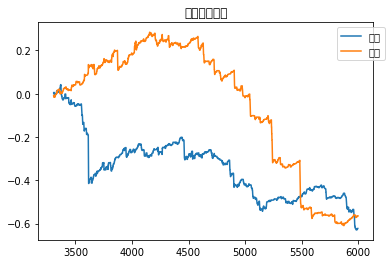

In [158]:
df_btc_test['y_buy'].cumsum().plot(label='買い')
df_btc_test['y_sell'].cumsum().plot(label='売り')
plt.title('累積リターン')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

In [159]:
df_btc_test['y_buy'].sum()

-0.6224216196041524

In [160]:
df_btc_test['y_sell'].sum()

-0.5644618710528639

# 今度

* よく使う機能を関数化する。

* 1分足データに変更してやってみる。

* 1分足データを集める
